In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'adult-income-dataset' dataset.
Path to dataset files: /kaggle/input/adult-income-dataset
['adult.csv']


## Load Data

In [4]:
df = pd.read_csv(path + '/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [6]:
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

age: [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
workclass: ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
fnlwgt: [226802  89814 336951 ... 129912 255835 257302]
education: ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
educational-num: [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
marital-status: ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation: ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Tr

## Feature Engineering

native country to US n Non-US

In [7]:
df['native_country_group'] = np.where(
    df['native-country'] == 'United-States',
    'US',
    'Non-US'
)
df = df.drop(columns=['native-country'])

df.native_country_group.value_counts()

,count
native_country_group,
US,43832
Non-US,5010


grouping workclass

In [8]:
df['workclass_group'] = df['workclass'].replace({
    'Federal-gov': 'Government',
    'State-gov': 'Government',
    'Local-gov': 'Government',
    'Self-emp-not-inc': 'Self-Employed',
    'Self-emp-inc': 'Self-Employed',
    'Without-pay': 'Other',
    'Never-worked': 'Other',
    '?': 'Unknown'
})
df = df.drop(columns=['workclass'])


df.workclass_group.value_counts()

,count
workclass_group,
Private,33906
Government,6549
Self-Employed,5557
Unknown,2799
Other,31


grouping occupation

In [9]:
occupation_map = {
    'Exec-managerial': 'White-Collar',
    'Prof-specialty': 'White-Collar',
    'Adm-clerical': 'White-Collar',
    'Sales': 'White-Collar',

    'Craft-repair': 'Blue-Collar',
    'Machine-op-inspct': 'Blue-Collar',
    'Transport-moving': 'Blue-Collar',
    'Handlers-cleaners': 'Blue-Collar',
    'Farming-fishing': 'Blue-Collar',

    'Priv-house-serv': 'Service',
    'Other-service': 'Service',
    'Protective-serv': 'Service',
    'Tech-support': 'Service',

    'Armed-Forces': 'Military',
    '?': 'Unknown'
}

df['occupation_group'] = df['occupation'].map(occupation_map)
df = df.drop(columns=['occupation'])

df.occupation_group.value_counts()

,count
occupation_group,
White-Collar,23373
Blue-Collar,15051
Service,7594
Unknown,2809
Military,15


capital gain n loss to binary

In [10]:
df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

df = df.drop(columns=['capital-gain', 'capital-loss'])

In [11]:
df.has_capital_gain.value_counts()

,count
has_capital_gain,
0,44807
1,4035


In [12]:
df.has_capital_loss.value_counts()

,count
has_capital_loss,
0,46560
1,2282


income to binary

In [13]:
df['income'] = df['income'].map({
    '<=50K': 0,
    '>50K': 1
})

df.income.value_counts()

,count
income,
0,37155
1,11687


education grouping

In [14]:
education_map = {
    'Preschool': 'Dropout',
    '1st-4th': 'Dropout',
    '5th-6th': 'Dropout',
    '7th-8th': 'Dropout',
    '9th': 'Dropout',
    '10th': 'Dropout',
    '11th': 'Dropout',
    '12th': 'Dropout',

    'HS-grad': 'HS-Grad',

    'Some-college': 'Associate',
    'Assoc-voc': 'Associate',
    'Assoc-acdm': 'Associate',

    'Bachelors': 'Bachelors',

    'Masters': 'Masters-PhD',
    'Doctorate': 'Masters-PhD',

    'Prof-school': 'Prof-School'
}

df['education_group'] = df['education'].map(education_map)

df = df.drop(columns=['education', 'educational-num'])

df.education_group.value_counts()

,count
education_group,
HS-Grad,15784
Associate,14540
Bachelors,8025
Dropout,6408
Masters-PhD,3251
Prof-School,834


drop fnlwgt n relationship

In [15]:
df = df.drop(columns=['fnlwgt', 'relationship'])

grouping marital-status to single n married

In [16]:
marital_map = {
    'Married-civ-spouse': 'Married',
    'Married-AF-spouse': 'Married',
    'Never-married': 'Single',
    'Divorced': 'Single',
    'Separated': 'Single',
    'Widowed': 'Single',
    'Married-spouse-absent': 'Single'
}
df['marital_group'] = df['marital-status'].map(marital_map)
df = df.drop(columns=['marital-status'])

df.marital_group.value_counts()

,count
marital_group,
Single,26426
Married,22416


grouping hour-per-week

In [17]:
def group_hours(hours):
    if hours < 40:
        return 'Part-Time'
    elif hours == 40:
        return 'Full-Time'
    else:
        return 'Overtime'

df['hpw_group'] = df['hours-per-week'].apply(group_hours)
df = df.drop(columns=['hours-per-week'])

df.hpw_group.value_counts()

,count
hpw_group,
Full-Time,22803
Overtime,14352
Part-Time,11687


cek data

In [18]:
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

age: [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
race: ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
gender: ['Male' 'Female']
income: [0 1]
native_country_group: ['US' 'Non-US']
workclass_group: ['Private' 'Government' 'Unknown' 'Self-Employed' 'Other']
occupation_group: ['Blue-Collar' 'Service' 'Unknown' 'White-Collar' 'Military']
has_capital_gain: [0 1]
has_capital_loss: [0 1]
education_group: ['Dropout' 'HS-Grad' 'Associate' 'Prof-School' 'Bachelors' 'Masters-PhD']
marital_group: ['Single' 'Married']
hpw_group: ['Full-Time' 'Overtime' 'Part-Time']


In [19]:
df.info()
df.isnull().sum()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   48842 non-null  int64 
 1   race                  48842 non-null  object
 2   gender                48842 non-null  object
 3   income                48842 non-null  int64 
 4   native_country_group  48842 non-null  object
 5   workclass_group       48842 non-null  object
 6   occupation_group      48842 non-null  object
 7   has_capital_gain      48842 non-null  int64 
 8   has_capital_loss      48842 non-null  int64 
 9   education_group       48842 non-null  object
 10  marital_group         48842 non-null  object
 11  hpw_group             48842 non-null  object
dtypes: int64(4), object(8)
memory usage: 4.5+ MB


,age,race,gender,income,native_country_group,workclass_group,occupation_group,has_capital_gain,has_capital_loss,education_group,marital_group,hpw_group
count,48842.000000,48842,48842,48842.000000,48842,48842,48842,48842.000000,48842.000000,48842,48842,48842
unique,NaN,5,2,NaN,2,5,5,NaN,NaN,6,2,3
top,NaN,White,Male,NaN,US,Private,White-Collar,NaN,NaN,HS-Grad,Single,Full-Time
freq,NaN,41762,32650,NaN,43832,33906,23373,NaN,NaN,15784,26426,22803
mean,38.643585,NaN,NaN,0.239282,NaN,NaN,NaN,0.082613,0.046722,NaN,NaN,NaN
std,13.710510,NaN,NaN,0.426649,NaN,NaN,NaN,0.275300,0.211045,NaN,NaN,NaN
min,17.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,28.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
50%,37.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
75%,48.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN


## EDA

income distribution

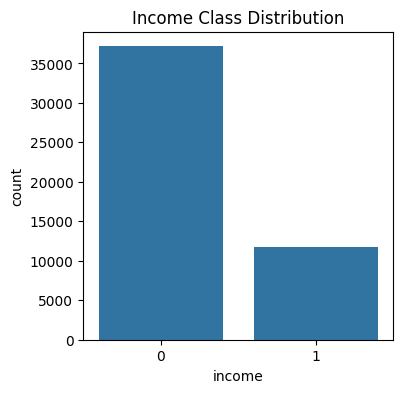

,proportion
income,
0,0.760718
1,0.239282


In [20]:
plt.figure(figsize=(4,4))
sns.countplot(x='income', data=df)
plt.title("Income Class Distribution")
plt.show()

df['income'].value_counts(normalize=True)

age vs income

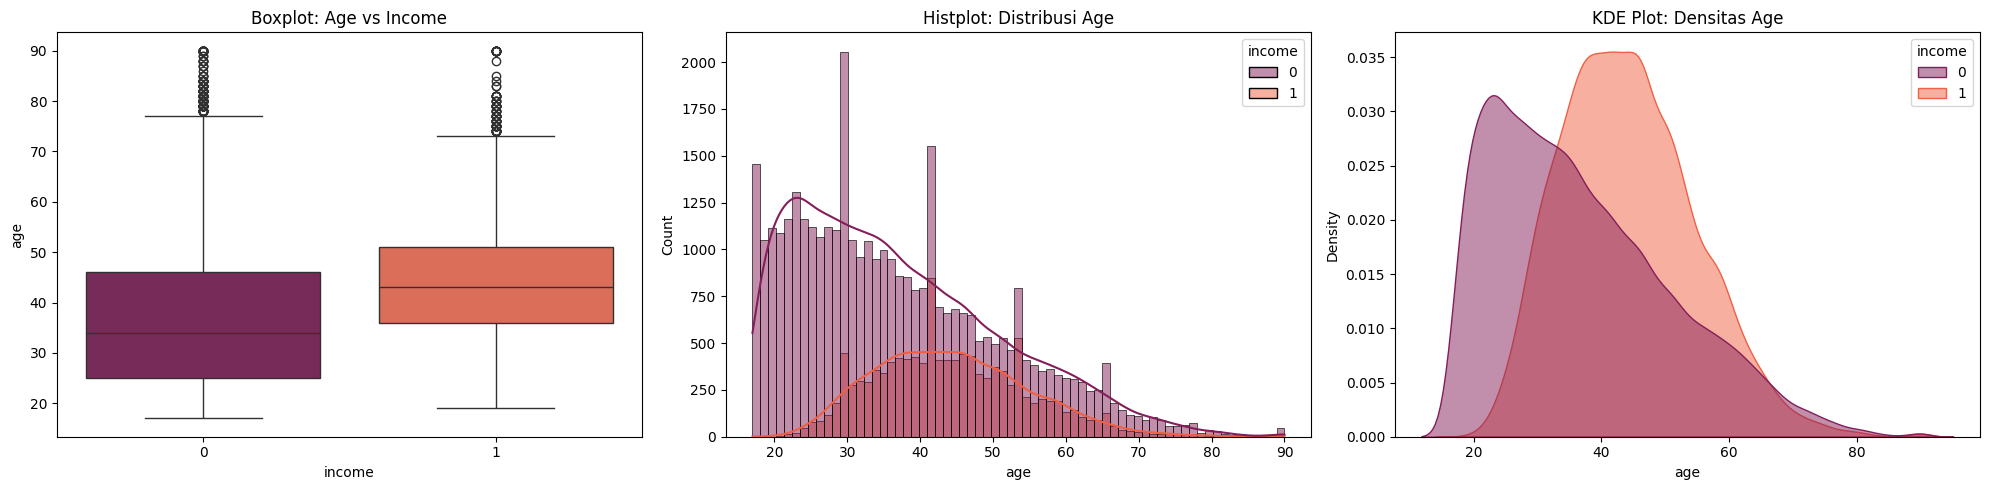

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(
    x=df['income'],
    y=df['age'],
    palette="rocket",
    ax=axes[0]
)
axes[0].set_title('Boxplot: Age vs Income')

sns.histplot(
    x=df['age'],
    hue=df['income'],
    kde=True,
    palette="rocket",
    ax=axes[1]
)
axes[1].set_title('Histplot: Distribusi Age')

sns.kdeplot(
    data=df,
    x='age',
    hue='income',
    fill=True,
    common_norm=False,
    palette='rocket',
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title('KDE Plot: Densitas Age')

plt.tight_layout()
plt.show()

categorical vs income

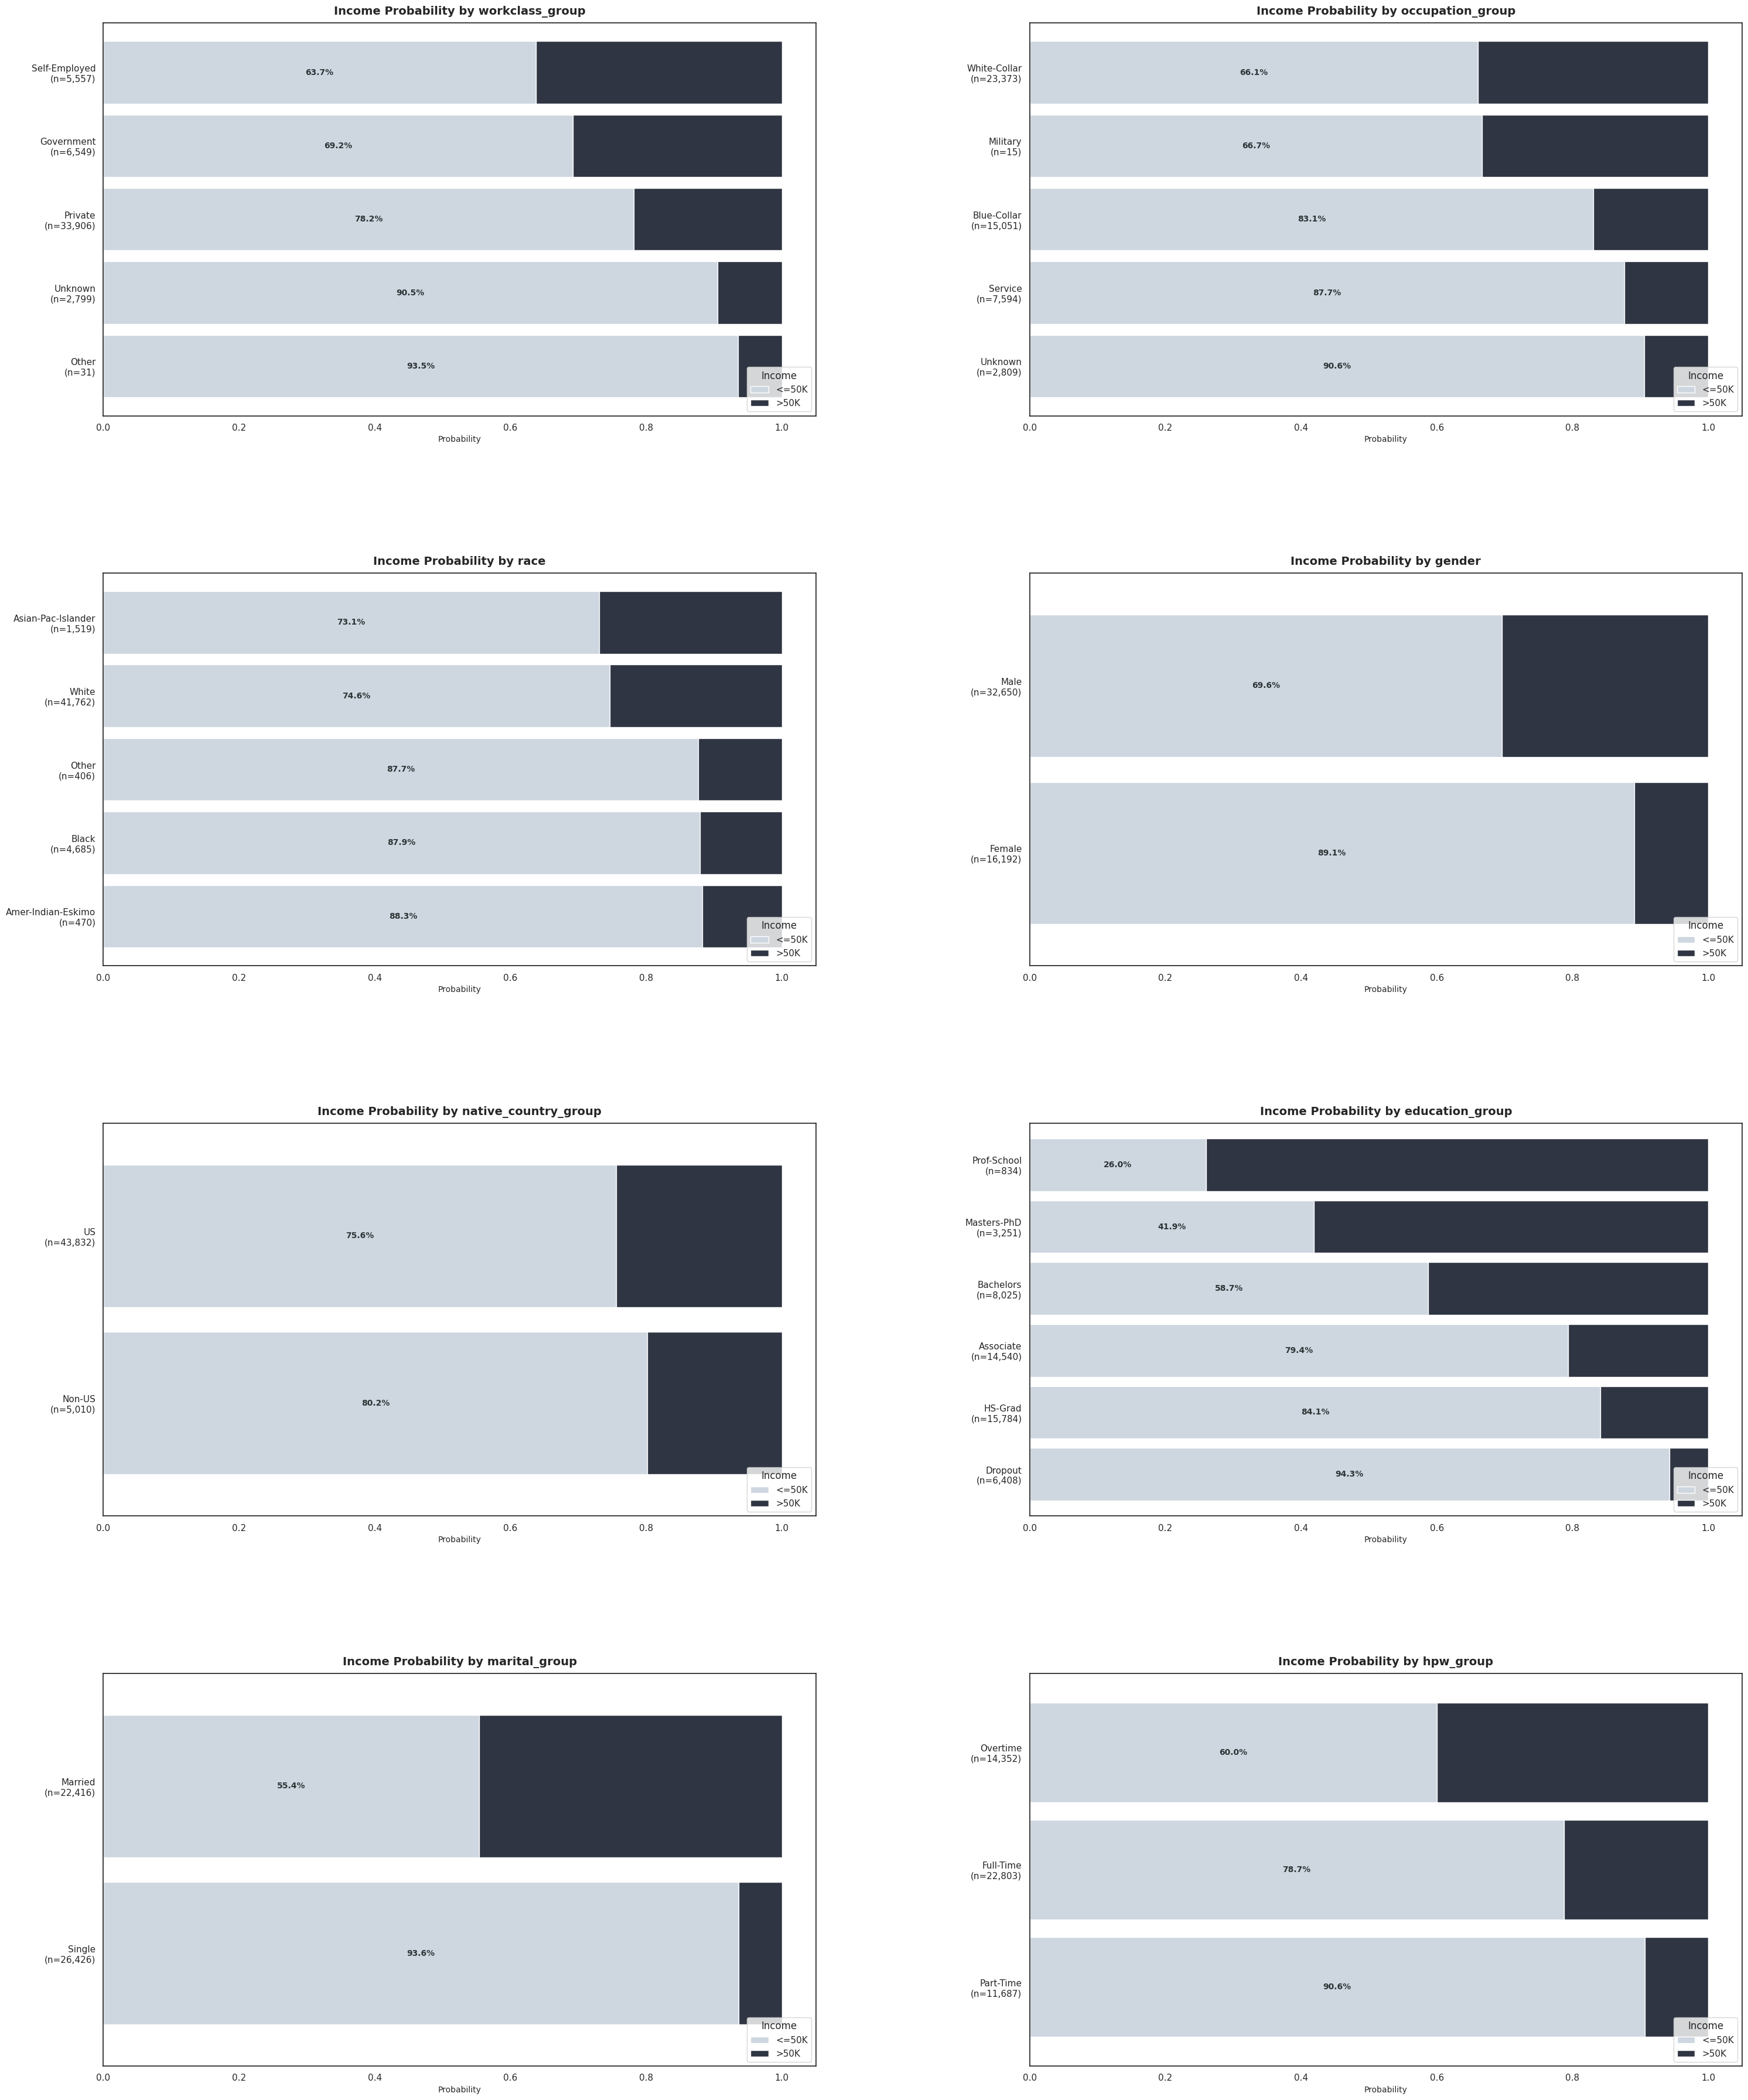

In [22]:
sns.set(style='white', font_scale=1.0)

cat_cols = [
    'workclass_group', 'occupation_group',
    'race', 'gender', 'native_country_group',
    'education_group', 'marital_group', 'hpw_group'
]

custom_colors = ['#ced6e0', '#2f3542']

fig, axes = plt.subplots(4, 2, figsize=(30, 36))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts()

    cross_tab = pd.crosstab(df[col], df['income'], normalize='index')

    try:
        target_col = cross_tab.columns[-1]
        cross_tab = cross_tab.sort_values(by=target_col, ascending=True)
    except:
        pass

    new_labels = []
    for cat_name in cross_tab.index:
        count_val = counts[cat_name]
        label_str = f"{cat_name}\n(n={count_val:,})"
        new_labels.append(label_str)

    cross_tab.index = new_labels

    cross_tab.plot(
        kind='barh',
        stacked=True,
        ax=axes[i],
        color=custom_colors,
        width=0.85,
        edgecolor='white'
    )

    axes[i].set_title(f'Income Probability by {col}', fontweight='bold', fontsize=14, pad=10)
    axes[i].set_xlabel('Probability', fontsize=10)
    axes[i].set_ylabel('')
    axes[i].legend(title='Income', loc='lower right', labels=['<=50K', '>50K'])

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab.loc[x], [n]):
            if proportion > 0.05:
                text_color = "white" if proportion == cross_tab.loc[x].iloc[-1] else "#2d3436"

                cum_pos = 0
                idx_col = 0
                if proportion == cross_tab.loc[x].iloc[0]:
                    pos_x = proportion / 2
                else:
                    pos_x = cross_tab.loc[x].iloc[0] + (proportion / 2)

                axes[i].text(
                    x=pos_x,
                    y=y_loc,
                    s=f'{np.round(proportion * 100, 1)}%',
                    color=text_color,
                    fontsize=10,
                    fontweight='bold',
                    ha='center', va='center'
                )

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

heatmap correlation

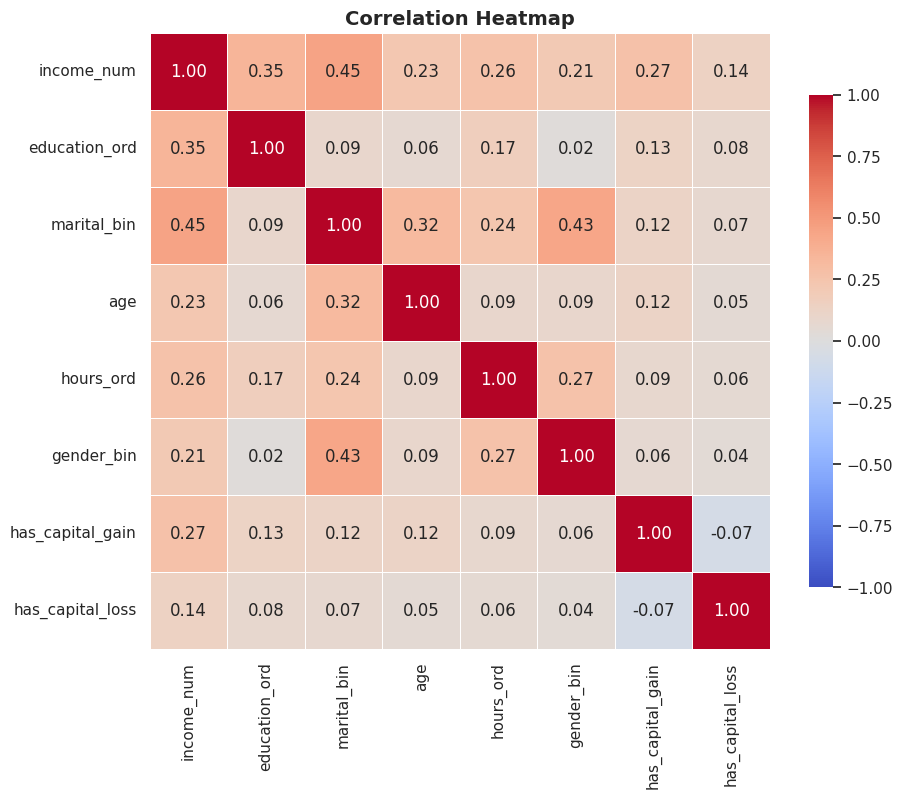

In [23]:
df_corr = df.copy()

df_corr['income_num'] = df_corr['income'].apply(lambda x: 1 if x == '>50K' or x == 1 else 0)

edu_map = {
    'Dropout': 0, 'HS-Grad': 1, 'Associate': 2,
    'Bachelors': 3, 'Masters-PhD': 4, 'Prof-School': 5
}
df_corr['education_ord'] = df_corr['education_group'].map(edu_map)

hours_map = {'Part-Time': 0, 'Full-Time': 1, 'Overtime': 2}
df_corr['hours_ord'] = df_corr['hpw_group'].map(hours_map)

df_corr['marital_bin'] = df_corr['marital_group'].apply(lambda x: 1 if x == 'Married' else 0)

df_corr['gender_bin'] = df_corr['gender'].apply(lambda x: 1 if x == 'Male' else 0)

corr_features = [
    'income_num',
    'education_ord',
    'marital_bin',
    'age',
    'hours_ord',
    'gender_bin',
    'has_capital_gain',
    'has_capital_loss'
]

plt.figure(figsize=(10, 8))
correlation_matrix = df_corr[corr_features].corr(method='pearson')

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1, vmax=1,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.show()

## Naive Bayes (GaussianNB)

In [24]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

In [25]:
numeric_features = ['age']

categorical_features = [
    'race', 'gender', 'native_country_group',
    'workclass_group', 'occupation_group',
    'education_group', 'marital_group',
    'hpw_group',
    'has_capital_gain', 'has_capital_loss'
]


preprocessing

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

pipeline

In [27]:
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])

nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['race', 'gender',
                                                   'native_country_group',
                                                   'workclass_group',
                                                   'occupation_group',
                                                   'education_group',
                                                   'marital_group', 'hpw_group',
                                                   'has_capital_gain',
                                                   'has_capital_loss'])])),
                ('model', GaussianNB())])

pred n eval

In [28]:
y_pred = nb_pipeline.predict(X_test)
y_proba = nb_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      7479
           1       0.53      0.74      0.62      2290

    accuracy                           0.79      9769
   macro avg       0.72      0.77      0.73      9769
weighted avg       0.82      0.79      0.80      9769



confusion matrix

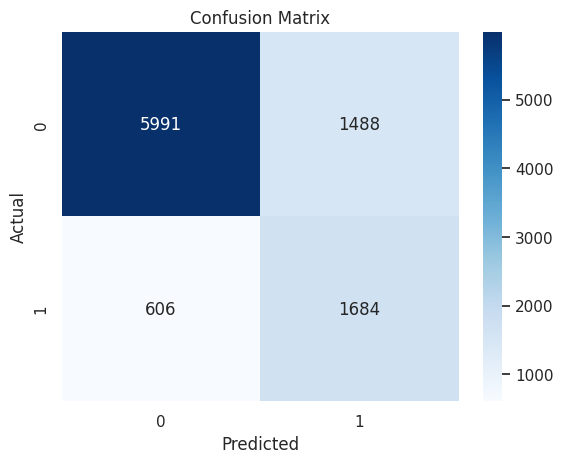

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ROC AUC

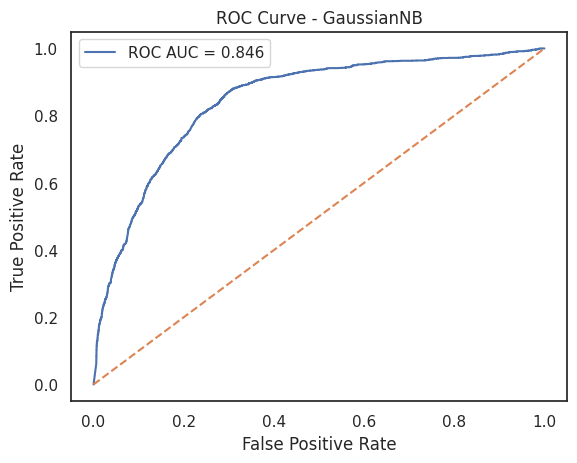

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB')
plt.legend()
plt.show()

precision recall

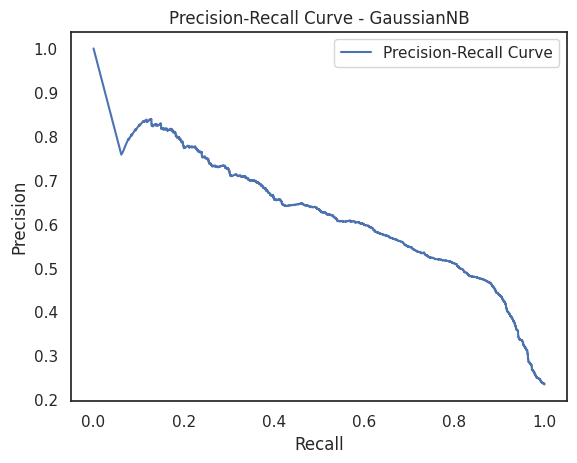

In [31]:
precision, recall, threshold = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB')
plt.legend()
plt.show()